[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AustinHouston/AReMS_2025/blob/main/2_NMF_CBED.ipynb)

In [ ]:
import os
import sys
import cv2
import numpy as np

# plotting
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
if 'google.colab' in sys.modules:
    # !pip install -q ipywidgets
    from google.colab import output
    output.enable_custom_widget_manager()


import SciFiReaders
import pyTEMlib
import pyTEMlib.file_tools as ft

# the star of the show:
from skimage.feature import blob_log, peak_local_max
from scipy.ndimage import gaussian_filter, correlate
from scipy.optimize import minimize
from skimage.draw import disk
from scipy.signal import fftconvolve
import concurrent.futures

from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

# clone the github repository
repo_url = 'https://github.com/AustinHouston/AReMS_2025.git'
repo_name = 'AReMS_2025'
if not os.path.exists(repo_name):
    !git clone {repo_url}


In [ ]:
# import the file
!wget https://figshare.com/s/ea79f506126ce14b162d

In [ ]:
path = './'
files = os.listdir(path)
mrc_file = [f for f in files if f.endswith('.mrc')][0]


dset = ft.open_file(path + mrc_file)
data = dset['Channel_000']

center = [135, 119]
size = 90

data = data[:,:, center[0]-size:center[0]+size, center[1]-size:center[1]+size]

In [ ]:
mrc_file

'20241005_123618.mrc'

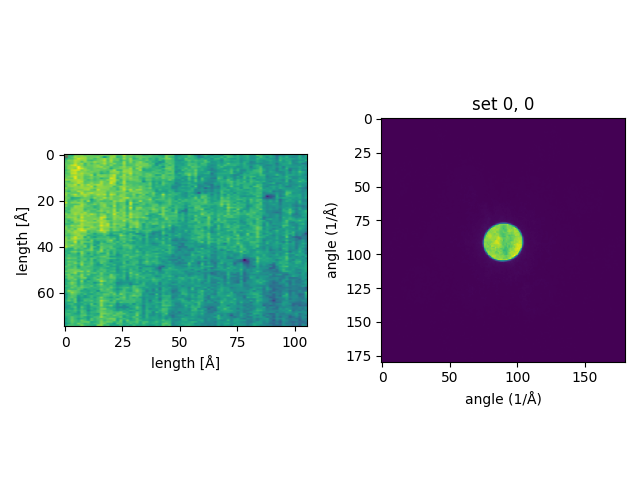

In [ ]:
view = data.plot()

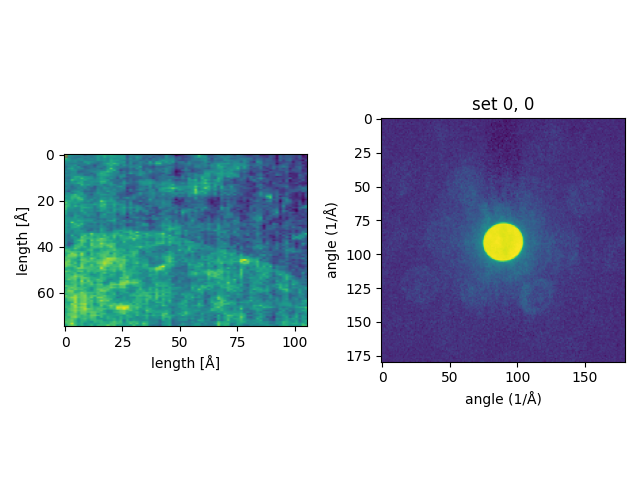

In [ ]:
data = data - data.min()
log_data = np.log(data + 1)
log_data = log_data - log_data.min()

view = log_data.plot()


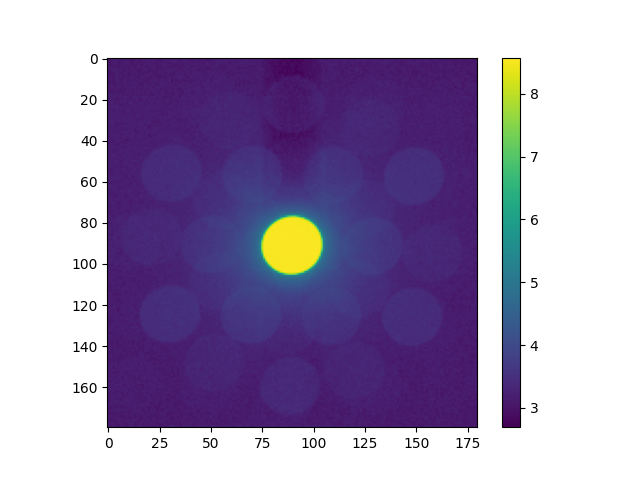

In [ ]:
# view the average
avg = log_data.mean(axis=(0,1))

fig, ax = plt.subplots()
ax.imshow(avg, cmap='viridis')
fig.colorbar(ax.imshow(avg, cmap='viridis'))

In [ ]:
log_norm = np.array(log_data)
log_norm = np.log2(log_norm + 1) - 1
log_norm = np.maximum(log_norm, 0) # if negative, set to 0
log_norm /= log_norm.max()


### K-Means clustering



In [ ]:
# first, reshape appropriately
log_array = np.array(log_norm)
log_array = log_array.reshape(-1, log_array.shape[-2], log_array.shape[-1])
log_array = log_array.reshape(-1, log_array.shape[-2]*log_array.shape[-1])
log_array.shape

(7950, 32400)

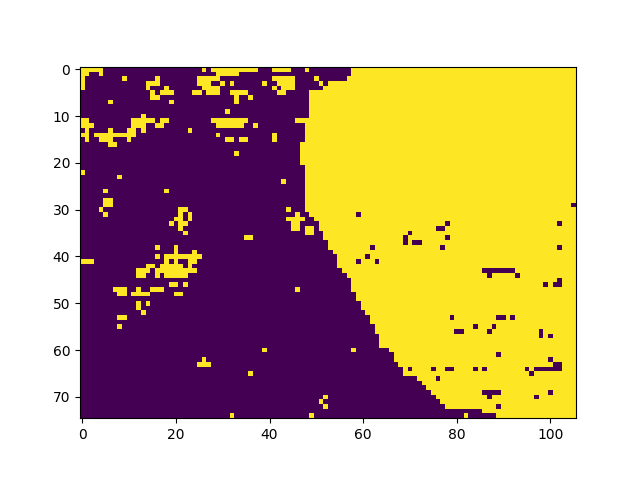

In [ ]:
# now, cluster
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(log_array)

# now, reshape back
labels = kmeans.labels_
labels = labels.reshape(log_data.shape[0], log_data.shape[1])

plt.figure()
plt.imshow(labels)

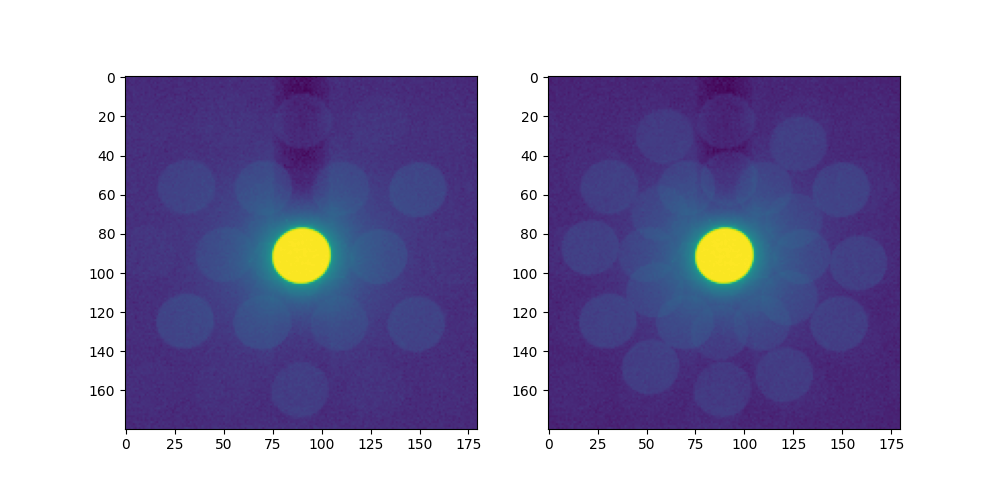

In [ ]:
# view the cluster centers
centers = kmeans.cluster_centers_
centers = centers.reshape(n_clusters, log_data.shape[-2], log_data.shape[-1])

fig, ax = plt.subplots(1, n_clusters, figsize=(10, 5))
for i in range(n_clusters):
    ax[i].imshow(centers[i])


### NMF

In [ ]:
n_components = 4
nmf = NMF(n_components = n_components, init = 'nndsvd', random_state = 42, max_iter = 1000)
W = nmf.fit_transform(log_array)
H = nmf.components_

W_reshaped = W.reshape(75, 106, n_components)
H_reshaped = H.reshape(n_components, 180, 180)

# print the reconstruction error
print(nmf.reconstruction_err_)

/Users/austin/miniconda3/envs/pytemlib/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


369.3849829446238


In [ ]:
cmaps = ['viridis', 'plasma', 'viridis', 'plasma']

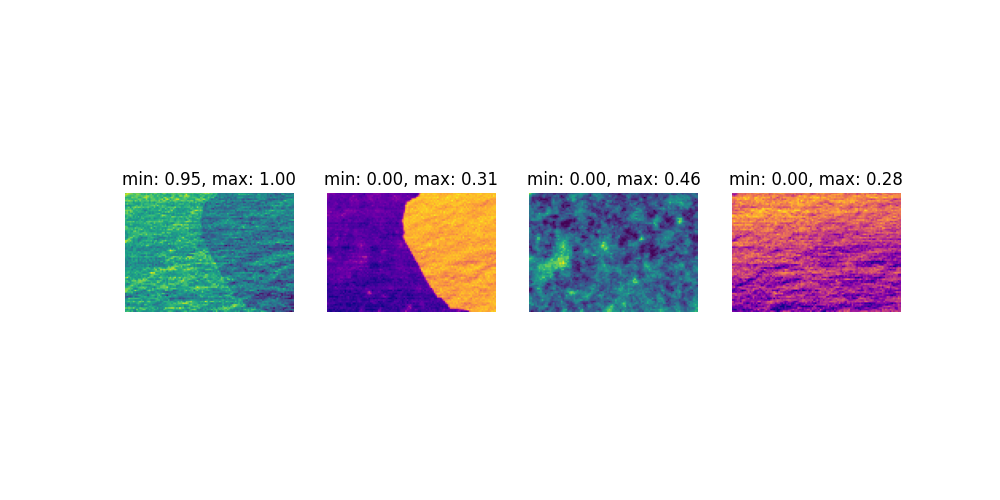

In [ ]:
# plot the results
fig, ax = plt.subplots(1, n_components, figsize=(10, 5))
for i in range(n_components):
    ax[i].imshow(W_reshaped[:,:,i], cmap=cmaps[i])
    ax[i].axis('off')
    ax[i].set_title(f'min: {W_reshaped[:,:,i].min():.2f}, max: {W_reshaped[:,:,i].max():.2f}')

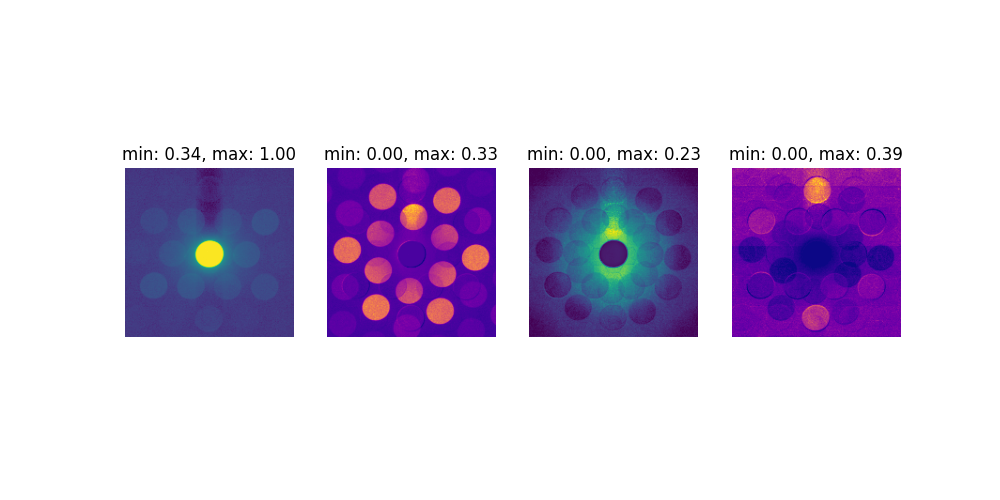

In [ ]:
fig, ax = plt.subplots(1, n_components, figsize=(10, 5))
for i in range(n_components):
    ax[i].imshow(H_reshaped[i], cmap=cmaps[i])
    ax[i].axis('off')
    ax[i].set_title(f'min: {H_reshaped[i].min():.2f}, max: {H_reshaped[i].max():.2f}')

### Strain from linescan

In [ ]:
file = './strained.csv'
strained_values = np.genfromtxt(file, delimiter=',', skip_header=1)
strain = strained_values[:,1]
x1 = strained_values[:,0]

file = './unstrained.csv'
unstrained_values = np.genfromtxt(file, delimiter=',', skip_header=1)
unstrained = unstrained_values[:,1]
x2 = unstrained_values[:,0]

([], [])

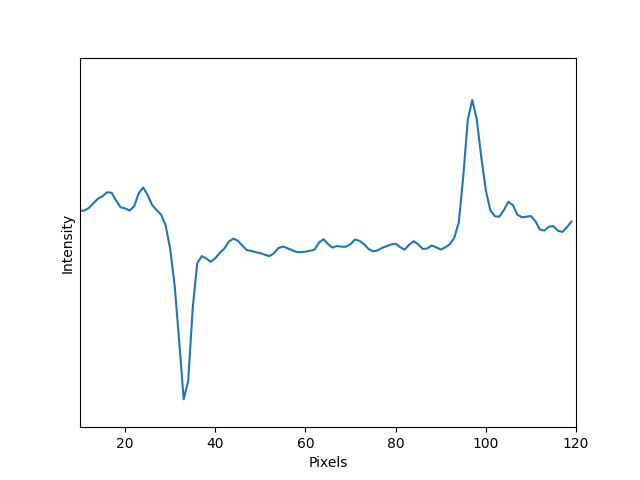

In [ ]:
plt.figure()
shift = 8
# plt.vlines(32.4, 40, 150, color='k', linestyle='--')
# plt.vlines(99.5, 40, 150, color='k', linestyle='--')
plt.plot(x1+shift,strain, label='strained')
# plt.plot(x2,unstrained, label='unstrained')

plt.xlim(10, 120)
plt.ylim(50, 130)
plt.xlabel('Pixels')
plt.ylabel('Intensity')
plt.yticks([])